In [407]:


import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, davies_bouldin_score

from xgboost import XGBRegressor

from utils.visualization import visualize_target_distribution
from utils.pipeline import create_pipeline
from utils.util import (
    undump_ZV, get_cols_containing, get_columns_by_type, feature_importances_to_df, get_feature_to_keep,
    reduce_features, measure_performace, load_data
)
from utils.outliers import (
    count_values_above_threshold, count_values_below_threshold, remove_outliers
    )
from utils.feature_engineering import (
    apply_feature_engineering
)
from utils.constants import (
    target_column, DATA_PATH, DATA_FILE_NAME, MACRO_FILE_NAME,
    categorical_columns
)

# Кластеры для районов
# Таргет трайнуть

In [408]:
pd.options.display.float_format = '{:.6f}'.format
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns if needed
np.set_printoptions(threshold=np.inf)  # For NumPy arrays

In [409]:
raw_data_df, raw_macro_df = load_data(DATA_PATH, [DATA_FILE_NAME, MACRO_FILE_NAME])

In [410]:
# print(raw_macro_df.info())

In [411]:
# raw_data_df.head(1)

In [412]:
# raw_macro_df.head()

In [413]:
# raw_data_df = raw_data_df.merge(macro, on="timestamp", how="left")

In [414]:
raw_data_df.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_av

In [415]:
# outliers_removed_df = remove_outliers(raw_data_df)
outliers_removed_df = raw_data_df

Col_name: price_doc
Skewness: 4.474744873569561
Upper_bound: 24532075.399999924
Dataset total rows: 30471
Number of rows > 24532075.399999924: 305
Number of NaN: 0
Col_name: price_doc
Number of rows < 20: 0


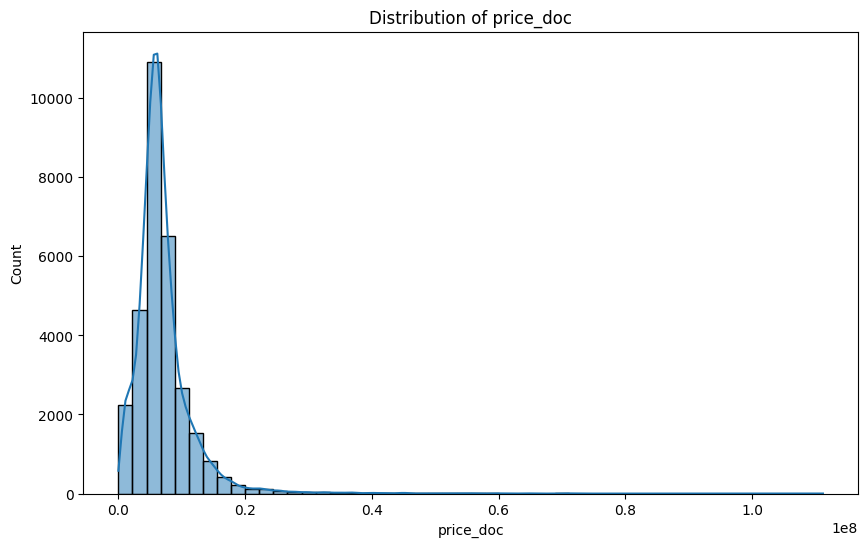

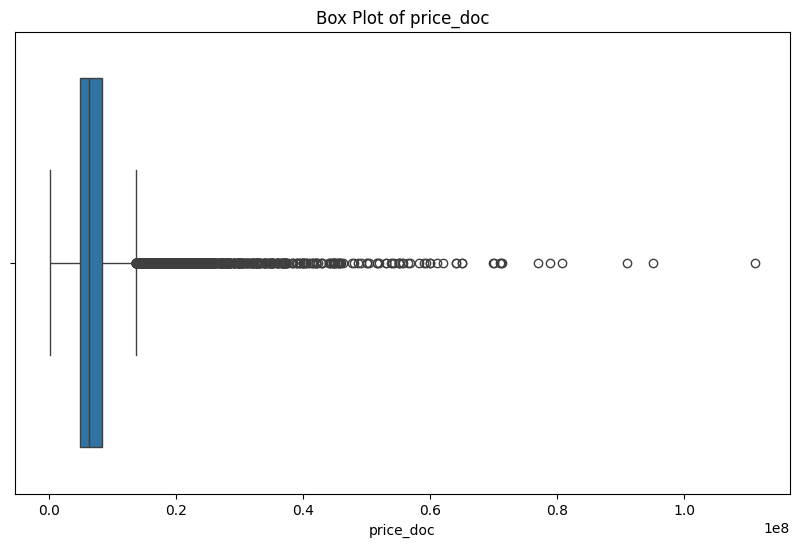

In [416]:
col_to_visualize = 'price_doc'
data_to_visualize = raw_data_df
data_to_visualize = outliers_removed_df
count_values_above_threshold(data_to_visualize, col_name=col_to_visualize)
count_values_below_threshold(data_to_visualize, col_to_visualize, 20)
visualize_target_distribution(data_to_visualize, col_to_visualize)

In [417]:
# data = Data_train
raw_data_df = outliers_removed_df

X = raw_data_df.drop(columns=[target_column])
y = raw_data_df[target_column]

In [418]:
df_cols = get_cols_containing(X, [
'university'
])
df_cols.head(1)

,university_top_20_raion,university_km
0,0,6.715026


In [419]:
# X = apply_feature_engineering(X, y)

In [420]:
numerical_columns, _ = get_columns_by_type(X)
all_columns = categorical_columns + numerical_columns

print(len(X.columns))
print(len(categorical_columns))
print(len(numerical_columns))

291
15
275


In [421]:
preprocessing_pipeline = create_pipeline(
    all_columns=all_columns,
    numerical_columns=numerical_columns,
    include_scaling=False,
    include_knn_imputation=False,
    include_ecology_imputation=False
)

X_processed = preprocessing_pipeline.fit_transform(X, y)

In [422]:
# from utils.util import dump_ZV


# preprocessing_pipeline = create_pipeline(
#     all_columns=all_columns,
#     numerical_columns=numerical_columns,
#     include_scaling=True,
#     include_knn_imputation=True,
#     include_ecology_imputation=True
# )

# processed_pipeline = preprocessing_pipeline.fit(X, y)
# X_scaled = processed_pipeline.transform(X)
# dump_ZV(X_scaled, 'X_scaled_for_DBSCAN_fi_custom_outliers')

In [423]:
# Cell 1: Load and Combine Data
X_scaled = undump_ZV('X_scaled_for_DBSCAN_all_features')

# Prepare the original dataset
X_copy = X.copy()  # Create a copy of the original features
if 'price_doc' not in X.columns:
    X_copy['price_doc'] = y 

# Scale the target independently
target_scaler = StandardScaler()
price_doc_scaled = target_scaler.fit_transform(y.values.reshape(-1, 1))

# Combine scaled features and target
X_scaled_combined = np.hstack([X_scaled, price_doc_scaled])


In [424]:
# Cell 2: PCA Dimensionality Reduction
n_components = 44
# n_components = 35
pca = PCA(n_components=n_components, random_state=42)
X_pca = pca.fit_transform(X_scaled_combined)


Number of components to retain 90% variance: 44


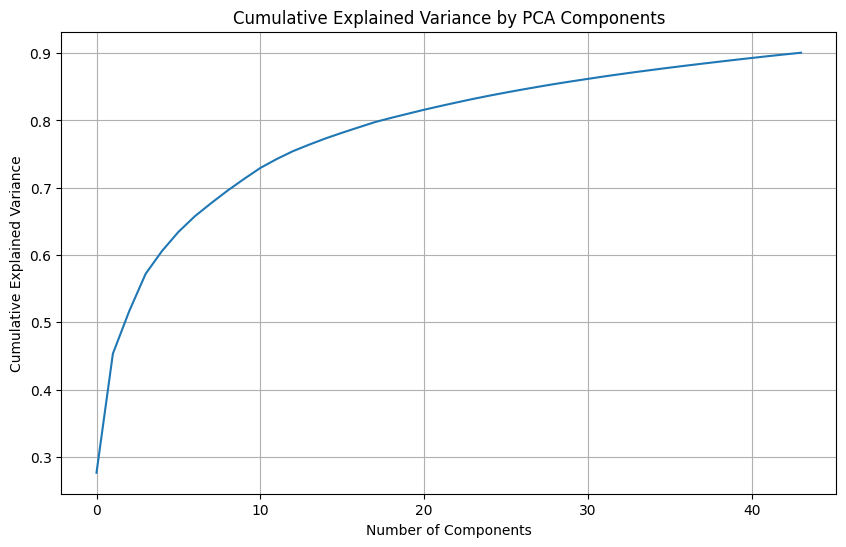

In [425]:
# Cell 3: Visualize PCA Explained Variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
# Find the number of components needed for 90% variance
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1  # Add 1 for index offset

print(f"Number of components to retain 90% variance: {n_components_90}")

plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance)
plt.title("Cumulative Explained Variance by PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid()
plt.show()


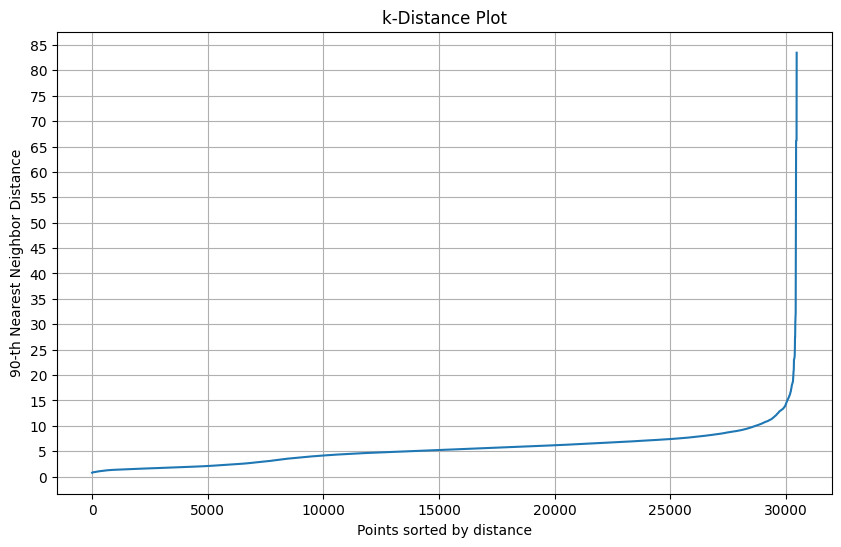

In [426]:
# Cell 4: K-Distance Plot for DBSCAN Parameter Tuning
# k = 70  # Use the same value as min_samples
k = 90  # Use the same value as min_samples
nbrs = NearestNeighbors(n_neighbors=k).fit(X_pca)
distances, _ = nbrs.kneighbors(X_pca)

# Plot the k-Distance
k_distances = np.sort(distances[:, k-1])

plt.figure(figsize=(10, 6))
plt.plot(k_distances)
plt.title("k-Distance Plot")
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{k}-th Nearest Neighbor Distance")

# Set granular y-axis ticks with a step of 5
y_min, y_max = plt.ylim()  # Get current y-axis limits
plt.yticks(np.arange(0, y_max + 1, 5))  # Set ticks from 0 to max with a step of 5

plt.grid()
plt.show()


In [427]:
# Cell 5: Apply DBSCAN
eps = 13  # Adjust based on k-Distance Plot elbow
dbscan = DBSCAN(eps=eps, min_samples=k, metric="euclidean", n_jobs=-1)
labels = dbscan.fit_predict(X_pca)

# Extract outlier indices
outlier_indices = np.where(labels == -1)[0]
outliers_original = X_copy.iloc[outlier_indices]  # Map outliers to the original dataset


In [428]:


# Exclude outliers (-1 labels) for these metrics
non_outlier_mask = labels != -1
silhouette = silhouette_score(X_pca[non_outlier_mask], labels[non_outlier_mask])
davies_bouldin = davies_bouldin_score(X_pca[non_outlier_mask], labels[non_outlier_mask])

print(f"Outliers detected: {len(outlier_indices)}")
print(f"Silhouette Score: {silhouette:.2f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.2f}")


Outliers detected: 304
Silhouette Score: 0.32
Davies-Bouldin Index: 0.53


In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np

# Define ranges for eps and min_samples
eps_values = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16]  # Adjust based on k-Distance Plot
min_samples_values = [60, 70, 80, 90, 100, 110, 120, 130, 140, 150]  # Based on dimensionality and domain knowledge

# Track the best parameters and scores
best_eps = None
best_min_samples = None
best_silhouette_score = -1
best_davies_bouldin_score = float('inf')  # Lower is better for Davies-Bouldin
results = []  # Store results for analysis

# Grid search for the best combination of eps and min_samples
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric="euclidean")
        labels = dbscan.fit_predict(X_pca)

        # Count outliers
        n_outliers = np.sum(labels == -1)

        # Exclude outliers for Silhouette Score and Davies-Bouldin Index
        if len(set(labels[labels != -1])) > 1:  # Avoid invalid clustering scores
            silhouette = silhouette_score(X_pca[labels != -1], labels[labels != -1])
            davies_bouldin = davies_bouldin_score(X_pca[labels != -1], labels[labels != -1])
        else:
            silhouette = -1  # Invalid clustering
            davies_bouldin = float('inf')  # Invalid clustering

        # Track results
        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'silhouette_score': silhouette,
            'davies_bouldin_score': davies_bouldin,
            'n_outliers': n_outliers
        })

        # Update best parameters based on Silhouette Score
        if silhouette > best_silhouette_score:
            best_silhouette_score = silhouette
            best_eps = eps
            best_min_samples = min_samples
            best_davies_bouldin_score = davies_bouldin

# Print the best combination
print(f"Best Silhouette Score: {best_silhouette_score:.2f}")
print(f"Best Davies-Bouldin Index: {best_davies_bouldin_score:.2f}")
print(f"Best eps: {best_eps}, Best min_samples: {best_min_samples}")


In [ ]:
# silhouette_score 
# 1.0 (Perfect Score): Indicates clusters are perfectly separated and all points are close to their cluster center. This is rare in real-world datasets.
# 0.7–1.0 (Excellent): Very well-defined clusters with strong separation.
# 0.5–0.7 (Good): Reasonably well-defined clusters with some overlap or noise.
# 0.25–0.5 (Moderate): Clusters may overlap, or the dataset has noise or complex shapes.
# 0.0–0.25 (Weak): Poor clustering; clusters are indistinct or overlap heavily.
# < 0.0 (Negative): Indicates that many points are closer to a different cluster than their assigned cluster. This suggests poor clustering or incorrect parameter choices.

# davies_bouldin_score 
# < 0.5: Excellent clustering with compact and well-separated clusters.
# 0.5–1.0: Decent clustering; may include some overlap or less compact clusters.
# > 1.0: Poor clustering, often indicating significant overlap between clusters or very dispersed clusters.

results_df = pd.DataFrame(results)
results_df

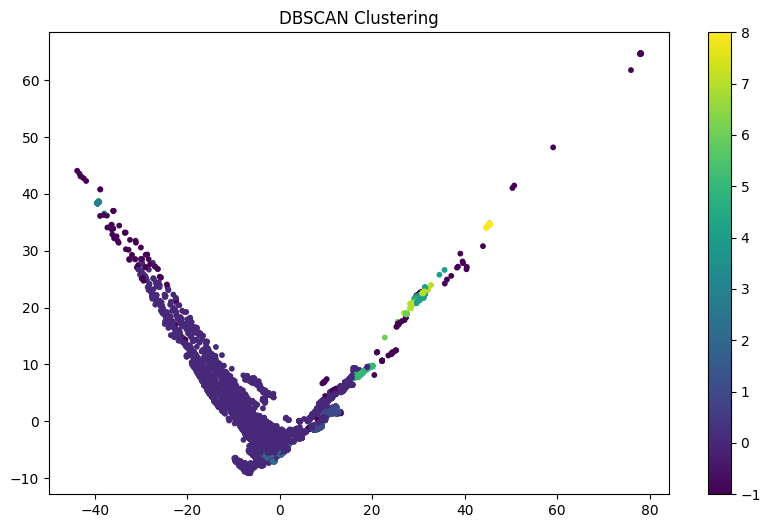

In [431]:
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=10)
plt.colorbar()
plt.title("DBSCAN Clustering")
plt.show()


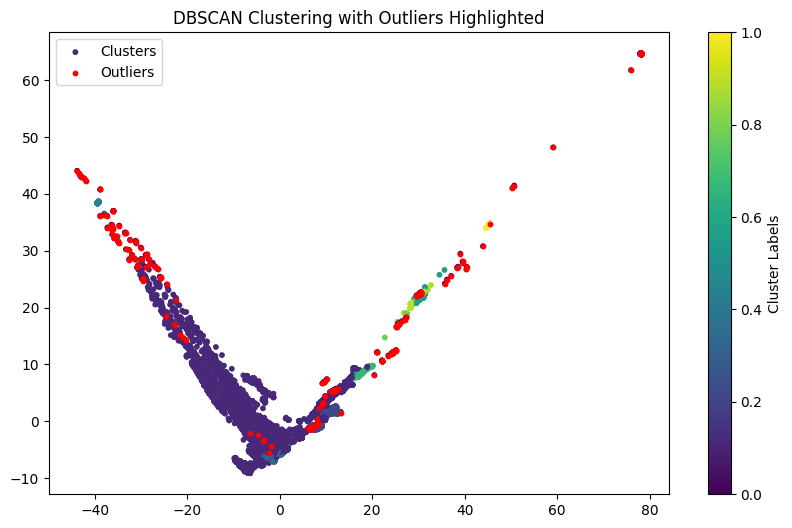

In [432]:
outlier_mask = (labels == -1)
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=10, label="Clusters")
plt.scatter(X_pca[outlier_mask, 0], X_pca[outlier_mask, 1], c='red', s=10, label="Outliers")
plt.colorbar(label="Cluster Labels")
plt.legend()
plt.title("DBSCAN Clustering with Outliers Highlighted")
plt.show()


In [433]:
# # Cell 6: Print Outliers Information
# top_20_features = [
#     'price_doc', 'full_sq', 'life_sq', 'floor', 'max_floor', 'build_year', 'num_room', 
#     'kitch_sq', 'state', 'kremlin_km', 'metro_km_walk', 'park_km', 'school_km', 
#     'kindergarten_km', 'shopping_centers_km', 'green_zone_km', 'railroad_station_walk_km', 
#     'industrial_km', 'cafe_count_500', 'market_count_500'
# ]

# # Analyze outliers with selected features
# outliers_top_features = outliers_original[top_20_features]

# print(f"Outliers detected: {len(outlier_indices)}")
# print("Sample Outliers in Original Dataset (Top 20 Features):")
# outliers_top_features.head(1)

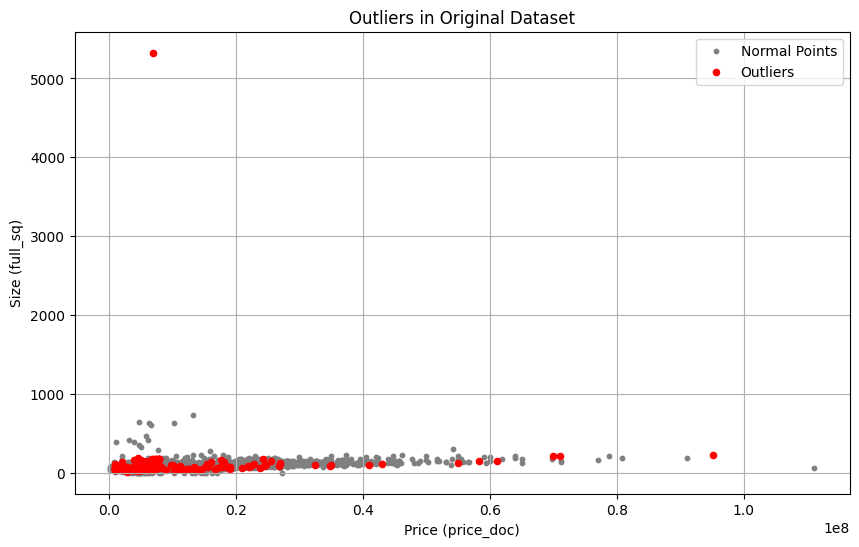

In [434]:
# Cell 7: Visualize Outliers in Original Features
plt.figure(figsize=(10, 6))
plt.scatter(X_copy['price_doc'], X_copy['full_sq'], c='gray', s=10, label='Normal Points')
plt.scatter(outliers_original['price_doc'], outliers_original['full_sq'], c='red', s=20, label='Outliers')
plt.title("Outliers in Original Dataset")
plt.xlabel("Price (price_doc)")
plt.ylabel("Size (full_sq)")
plt.legend()
plt.grid()
plt.show()


In [435]:
reduced_features = ['sub_area']
reduced_features = all_columns

X_reduced, features_reduced = reduce_features(X_processed, all_columns, reduced_features)

Reduced dimensionality: 290 → 290 (Rows: 30471)


In [436]:
X_reduced = np.delete(X_reduced, outlier_indices, axis=0)  # Drop outlier rows

# Assuming y is also a NumPy array, exclude corresponding rows in y
y = np.delete(y, outlier_indices, axis=0)  # Drop the same rows in target

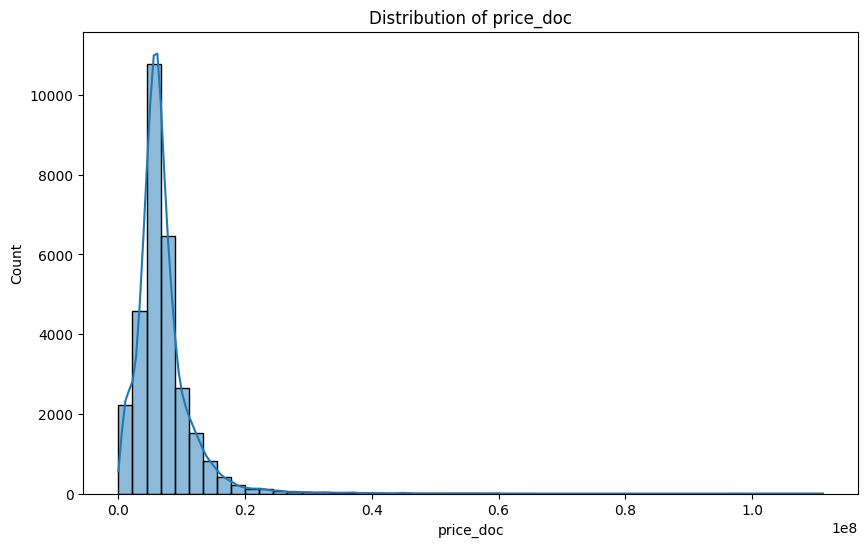

In [437]:
    import seaborn as sns

    # Plot Distribution (Histogram + KDE)
    plt.figure(figsize=(10, 6))
    sns.histplot(y, kde=True, bins=50)
    plt.title(f'Distribution of {target_column}')
    plt.xlabel(target_column)
    plt.show()

In [438]:
bins = np.linspace(y.min(), y.max(), 2)  # 10 bins
y_binned = np.digitize(y, bins)

In [439]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

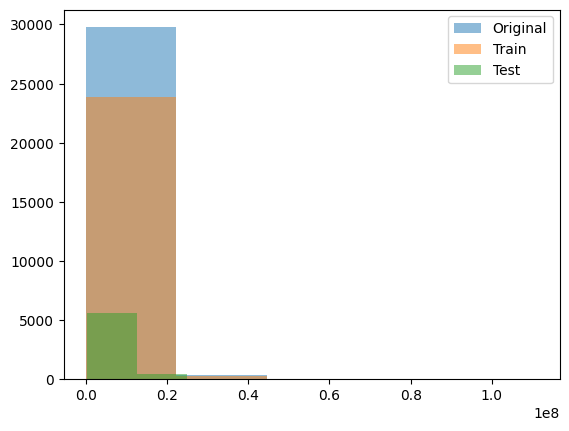

In [440]:
plt.hist(y, bins=5, alpha=0.5, label="Original")
plt.hist(y_train, bins=5, alpha=0.5, label="Train")
plt.hist(y_test, bins=5, alpha=0.5, label="Test")
plt.legend()
plt.show()

In [441]:
model = XGBRegressor(
    n_estimators=100,        # Number of trees
    learning_rate=0.1,       # Step size shrinkage used to prevent overfitting
    max_depth=6,             # Maximum tree depth
    subsample=0.8,           # Subsample ratio of the training instances
    colsample_bytree=0.8,    # Subsample ratio of columns for each split
    random_state=42
)

measure_performace(model, X_train, y_train, X_test, y_test)

Cross-Validated RMSE: 2672131.44072754
Cross-Validated R^2 Score: 0.6795276403427124
Cross-Validated LRMSE: 0.4685179630803473

Test RMSE: 2479852.106713952
Test R^2 Score: 0.6970300674438477
Test LRMSE: 0.47190220944297373

Test MSLE: 0.22269169527716023



In [442]:
model_fi = XGBRegressor(
    n_estimators=100,        # Number of trees
    learning_rate=0.1,       # Step size shrinkage used to prevent overfitting
    max_depth=6,             # Maximum tree depth
    subsample=0.8,           # Subsample ratio of the training instances
    colsample_bytree=0.8,    # Subsample ratio of columns for each split
    random_state=42
)
model_fi.fit(X_train, y_train)
feature_importances_df = feature_importances_to_df(features_reduced, model_fi.feature_importances_)
features_to_keep = get_feature_to_keep(feature_importances_df, threshold = 0.01)

                                    Feature  Importance
Rank                                                   
1                cafe_count_3000_price_2500    0.050453
2                           office_sqm_5000    0.042488
3                           cafe_count_3000    0.033151
4                cafe_count_3000_price_high    0.031667
5                           cafe_count_1000    0.030327
6                                  num_room    0.028660
7                                  sub_area    0.025408
8                                   full_sq    0.025121
9                           cafe_count_2000    0.024714
10               cafe_count_5000_price_2500    0.020642
11                        church_count_5000    0.015541
12                         sport_count_3000    0.014884
13                 cafe_count_1000_na_price    0.014320
14                          big_road1_1line    0.013984
15               cafe_count_2000_price_2500    0.013468
16               cafe_count_1500_price_high    0